# Imports and Paths

In [1]:
import os

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

import matplotlib.gridspec as gridspec
import datetime as dt
mpl.rcParams['figure.facecolor'] = 'white'
import time

from palettable.cartocolors.qualitative import Prism_8
prism = Prism_8.mpl_colors
import xarray as xr
blue = prism[1]
green = prism[3]
purple = prism[0]
red = prism[7]
orange = prism[6]
yellow = prism[5]
gray = '#303039'

from palettable.cmocean.sequential import Tempo_20
tempo = mcolors.ListedColormap(Tempo_20.mpl_colors)
from palettable.cmocean.diverging import Balance_20
bal = Balance_20.mpl_colormap
from palettable.cmocean.diverging import Curl_20

curltop =  mcolors.ListedColormap(Curl_20.mpl_colors[10:])
curlbot =  mcolors.ListedColormap(Curl_20.mpl_colors[:10])
import sys
from palettable.cmocean.sequential import Deep_20
deep = mcolors.ListedColormap(Deep_20.mpl_colors)

from palettable.cmocean.diverging import Balance_20
bal = Balance_20.mpl_colormap

from palettable.cartocolors.diverging import Geyser_7
curl = Geyser_7.mpl_colormap

bal.set_bad('white')

from shared_functions import get_var
from run_params import *

In [2]:
style = '/home/gleung/scripts/styles/bee-paperlight.mplstyle'
plt.style.use(style)

import matplotlib.font_manager as font_manager
from matplotlib import rcParams
 
# Add every font at the specified location
font_dir = ['/home/gleung/scripts/futura']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

# Set font family globally
rcParams['font.family'] = 'Futura'
rcParams["figure.facecolor"] = 'white'
rcParams['figure.dpi'] = 300  

In [3]:
dataPath = f"/camp2e/gleung/aerograd"

anaPath = f"/camp2e/gleung/aerograd-analysis/"
figPath = f"/camp2e/gleung/aerograd-figures/paper-revisions/"

if not os.path.isdir(figPath):
    os.mkdir(figPath)

# Figure: Cross-Section

In [4]:
def plot_cross_section(run, time='0-12', 
                        con_levels=np.logspace(-5,0,6),
                        sw_levels=np.linspace(300,400,11),
                        low_aerosol_run=''):

    plot = pd.read_pickle(f"{anaPath}{run}/mean_cross_section-{time}.pkl")
    suba = pd.read_pickle(f"{anaPath}{run}/mean_surf_flux-{time}.pkl")
    winds = pd.read_pickle(f"{anaPath}{run}/mean_wind-{time}.pkl")

    if low_aerosol_run:
        suba_low = pd.read_pickle(f"{anaPath}{low_aerosol_run}/mean_surf_flux-{time}.pkl")

    fig = plt.figure(figsize=(9,6), constrained_layout=False, tight_layout=False)

    spec = gridspec.GridSpec(ncols=2, nrows=3, figure=fig)
    ax1 = fig.add_subplot(spec[0:2, 0])
    ax2 = fig.add_subplot(spec[0:2, 1], sharex=ax1, sharey=ax1)
    ax3 = fig.add_subplot(spec[2, 0], sharex=ax1)
    ax4 = fig.add_subplot(spec[2, 1], sharex=ax1)

    fig.subplots_adjust(wspace=0.375,hspace=0.25)

    ax = ax1
    c = ax.contourf(sorted(plot.abs_hdist.unique()), alt[1:-1]/1000, 
                 plot.pivot(index='z',columns='abs_hdist',values='TCON')*1000,
                norm = mcolors.LogNorm(),
                levels = con_levels,
                extend='both',
                cmap= deep)

    ax.xaxis.set_visible(False)

    cax = fig.add_axes([ax.get_position().x1 + 0.01, 
                           ax.get_position().y0,
                           0.025,
                           ax.get_position().y1 - ax.get_position().y0])
    plt.colorbar(c,cax=cax, format=mticker.LogFormatterMathtext(),
                label = 'g kg$^{-1}$')

    ax = ax2
    c = ax.contourf(sorted(plot.abs_hdist.unique()), alt[1:-1]/1000, 
                 plot.pivot(index='z',columns='abs_hdist',values='SWDN'),
                levels = sw_levels,
                    extend='both',
                cmap=curltop)

    ax.xaxis.set_visible(False)

    cax = fig.add_axes([ax.get_position().x1 + 0.01, 
                           ax.get_position().y0,
                           0.025,
                           ax.get_position().y1 - ax.get_position().y0])
    plt.colorbar(c,cax=cax,
                label = 'W m$^{-2}$')

    for ax in [ax1,ax2]:
        q = ax.quiver(winds.abs_hdist, winds.alt, 
               winds.VC, winds.WC*5,
             scale = 8, width=6E-3)

        ax.set_ylim(0,8)

    ax1.quiverkey(q, 1.1, 1.05, 1, r'$1 \frac{m}{s}$', labelpos='E',
                       coordinates='axes')

    ax1.set_ylabel('Altitude (km)')

    ax3.plot(suba.index, suba.AODT.rolling(5).mean(),color='black',
            label = 'Gradient')

    if low_aerosol_run:
        ax3.plot(suba_low.index, suba_low.AODT.rolling(5).mean(),color='black',ls='--',lw=1,
            label = 'Reduced-Gradient')

        ax3.legend()
    

    ax4.plot(suba.index, suba.SFLUX_T, color=red)
    if low_aerosol_run: ax4.plot(suba_low.index, suba_low.SHSFLUX_TF, color=red, ls = '--', lw=1)

    ax4b = ax4.twinx()
    ax4b.plot(suba.index, suba.SFLUX_R, color=blue)
    if low_aerosol_run: ax4b.plot(suba_low.index, suba_low.SFLUX_R, color=blue, ls = '--',lw=1)

    ax4.set_ylabel('Sensible (W m$^{{-2}}$)')
    ax4b.set_ylabel('Latent (W m$^{{-2}}$)')

    ax4.yaxis.label.set_color(red)
    ax4.tick_params(axis='y', colors=red)
    ax4b.yaxis.label.set_color(blue)
    ax4b.tick_params(axis='y', colors=blue)

    for ax in [ax3,ax4]:
        ax.set_xlabel('Distance from Maximum Aerosol (km)')

    ax1.set_xlim(0,50)

    ax1.set_title("(a) Cloud Condensate")
    ax2.set_title("(b) Downwelling Shortwave")
    ax3.set_title("(c) Aerosol Optical Depth")
    ax4.set_title("(d) Surface Heat Fluxes")

    plt.savefig(f"{figPath}/{run}-cross_full_mean-{time}.png",
                dpi=300,bbox_inches='tight')
    
    plt.show()
    plt.close('all')
     


/tmp/ipykernel_24022/332280942.py:24: UserWarning: Log scale: values of z <= 0 have been masked
  c = ax.contourf(sorted(plot.abs_hdist.unique()), alt[1:-1]/1000,


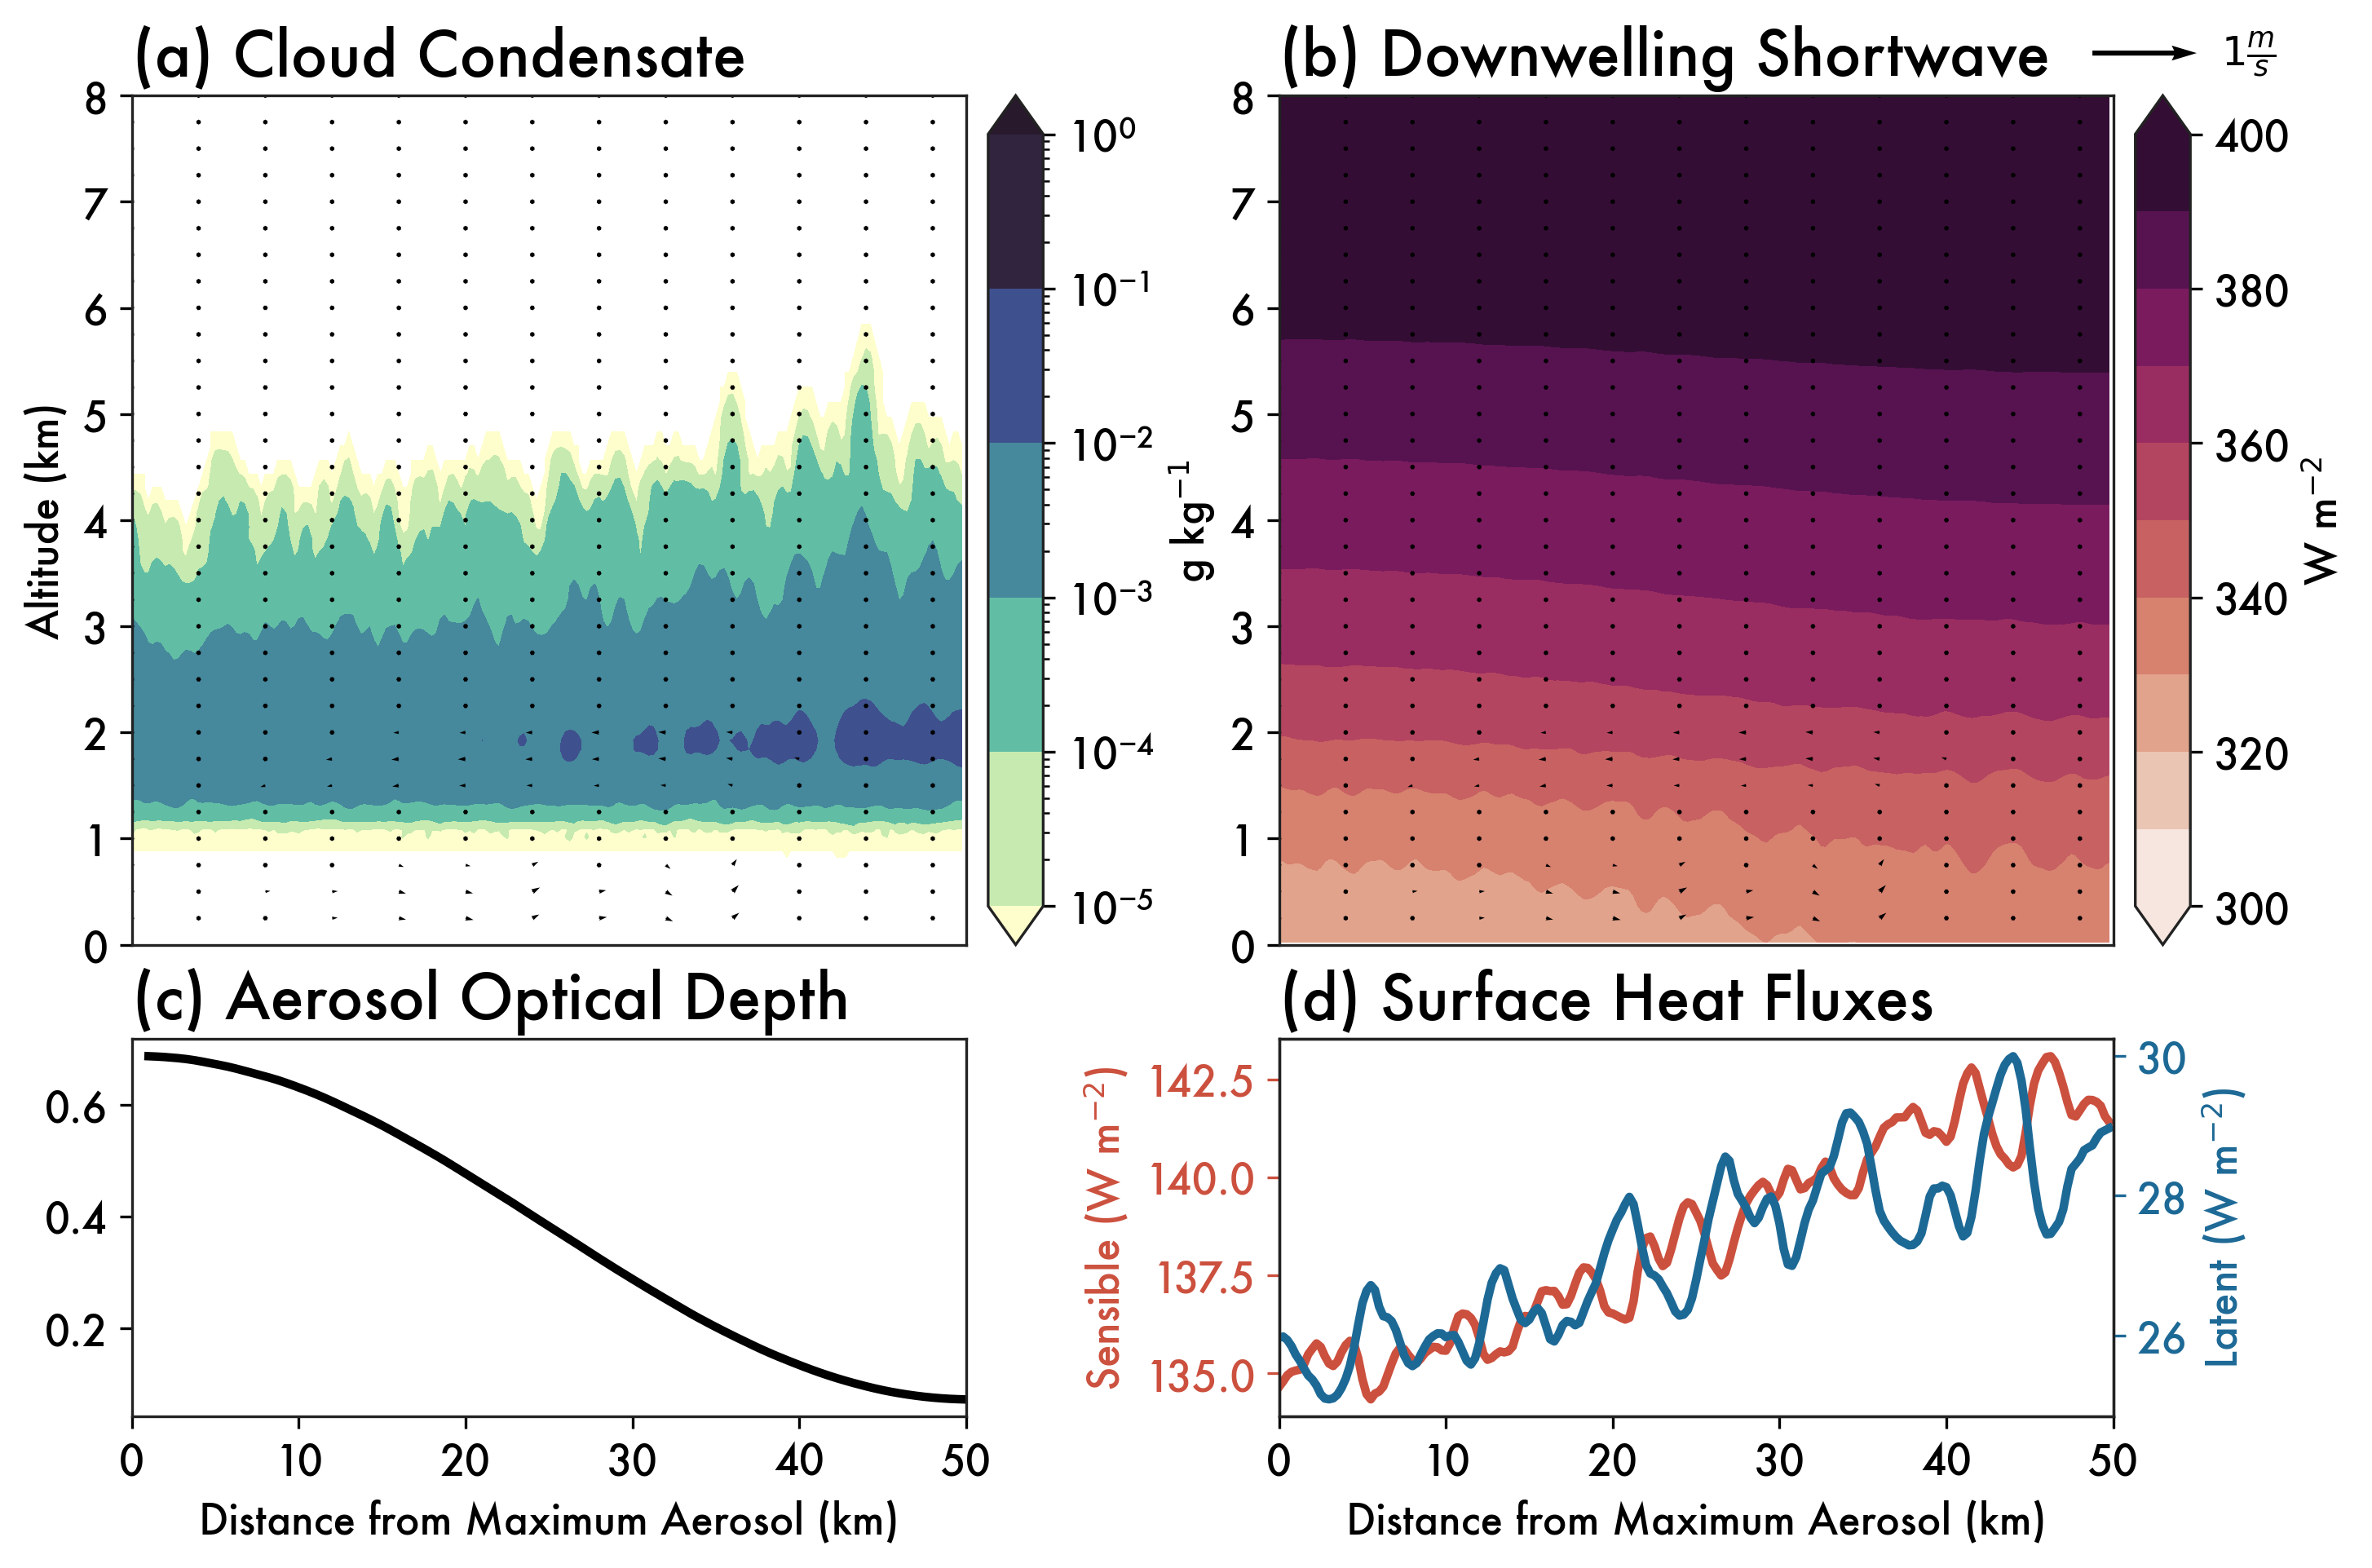

In [5]:
'''runs = ['grad.diurn']
times = [f"{h}-{h+1}" for h in range(4,7)]'''

runs = ['grad.500']
times = ['0-12']

for run in runs:
    for time in times:
        plot_cross_section(run, time=time,
                        #low_aerosol_run='grad.500'
                        #con_levels=np.logspace(-5,1,7),
                        #sw_levels=np.linspace(600,1400,11)
                        )

# Figure: Timeseries

In [165]:
def plot_timeseries(ax, run, var, run_color=None, run_ls=None, run_label=None):
    plot = pd.read_pickle(f"{anaPath}{run}/timeseries.pkl")
    
    if run.split('.')[-1]!='1000':
        lw = 1
    else:
        lw = 2.5
        
    out = ax.plot(plot.index/12, plot[var],
                 color=run_color, linestyle = run_ls,
                  label = run_label,
                 lw = lw)

    return(out)

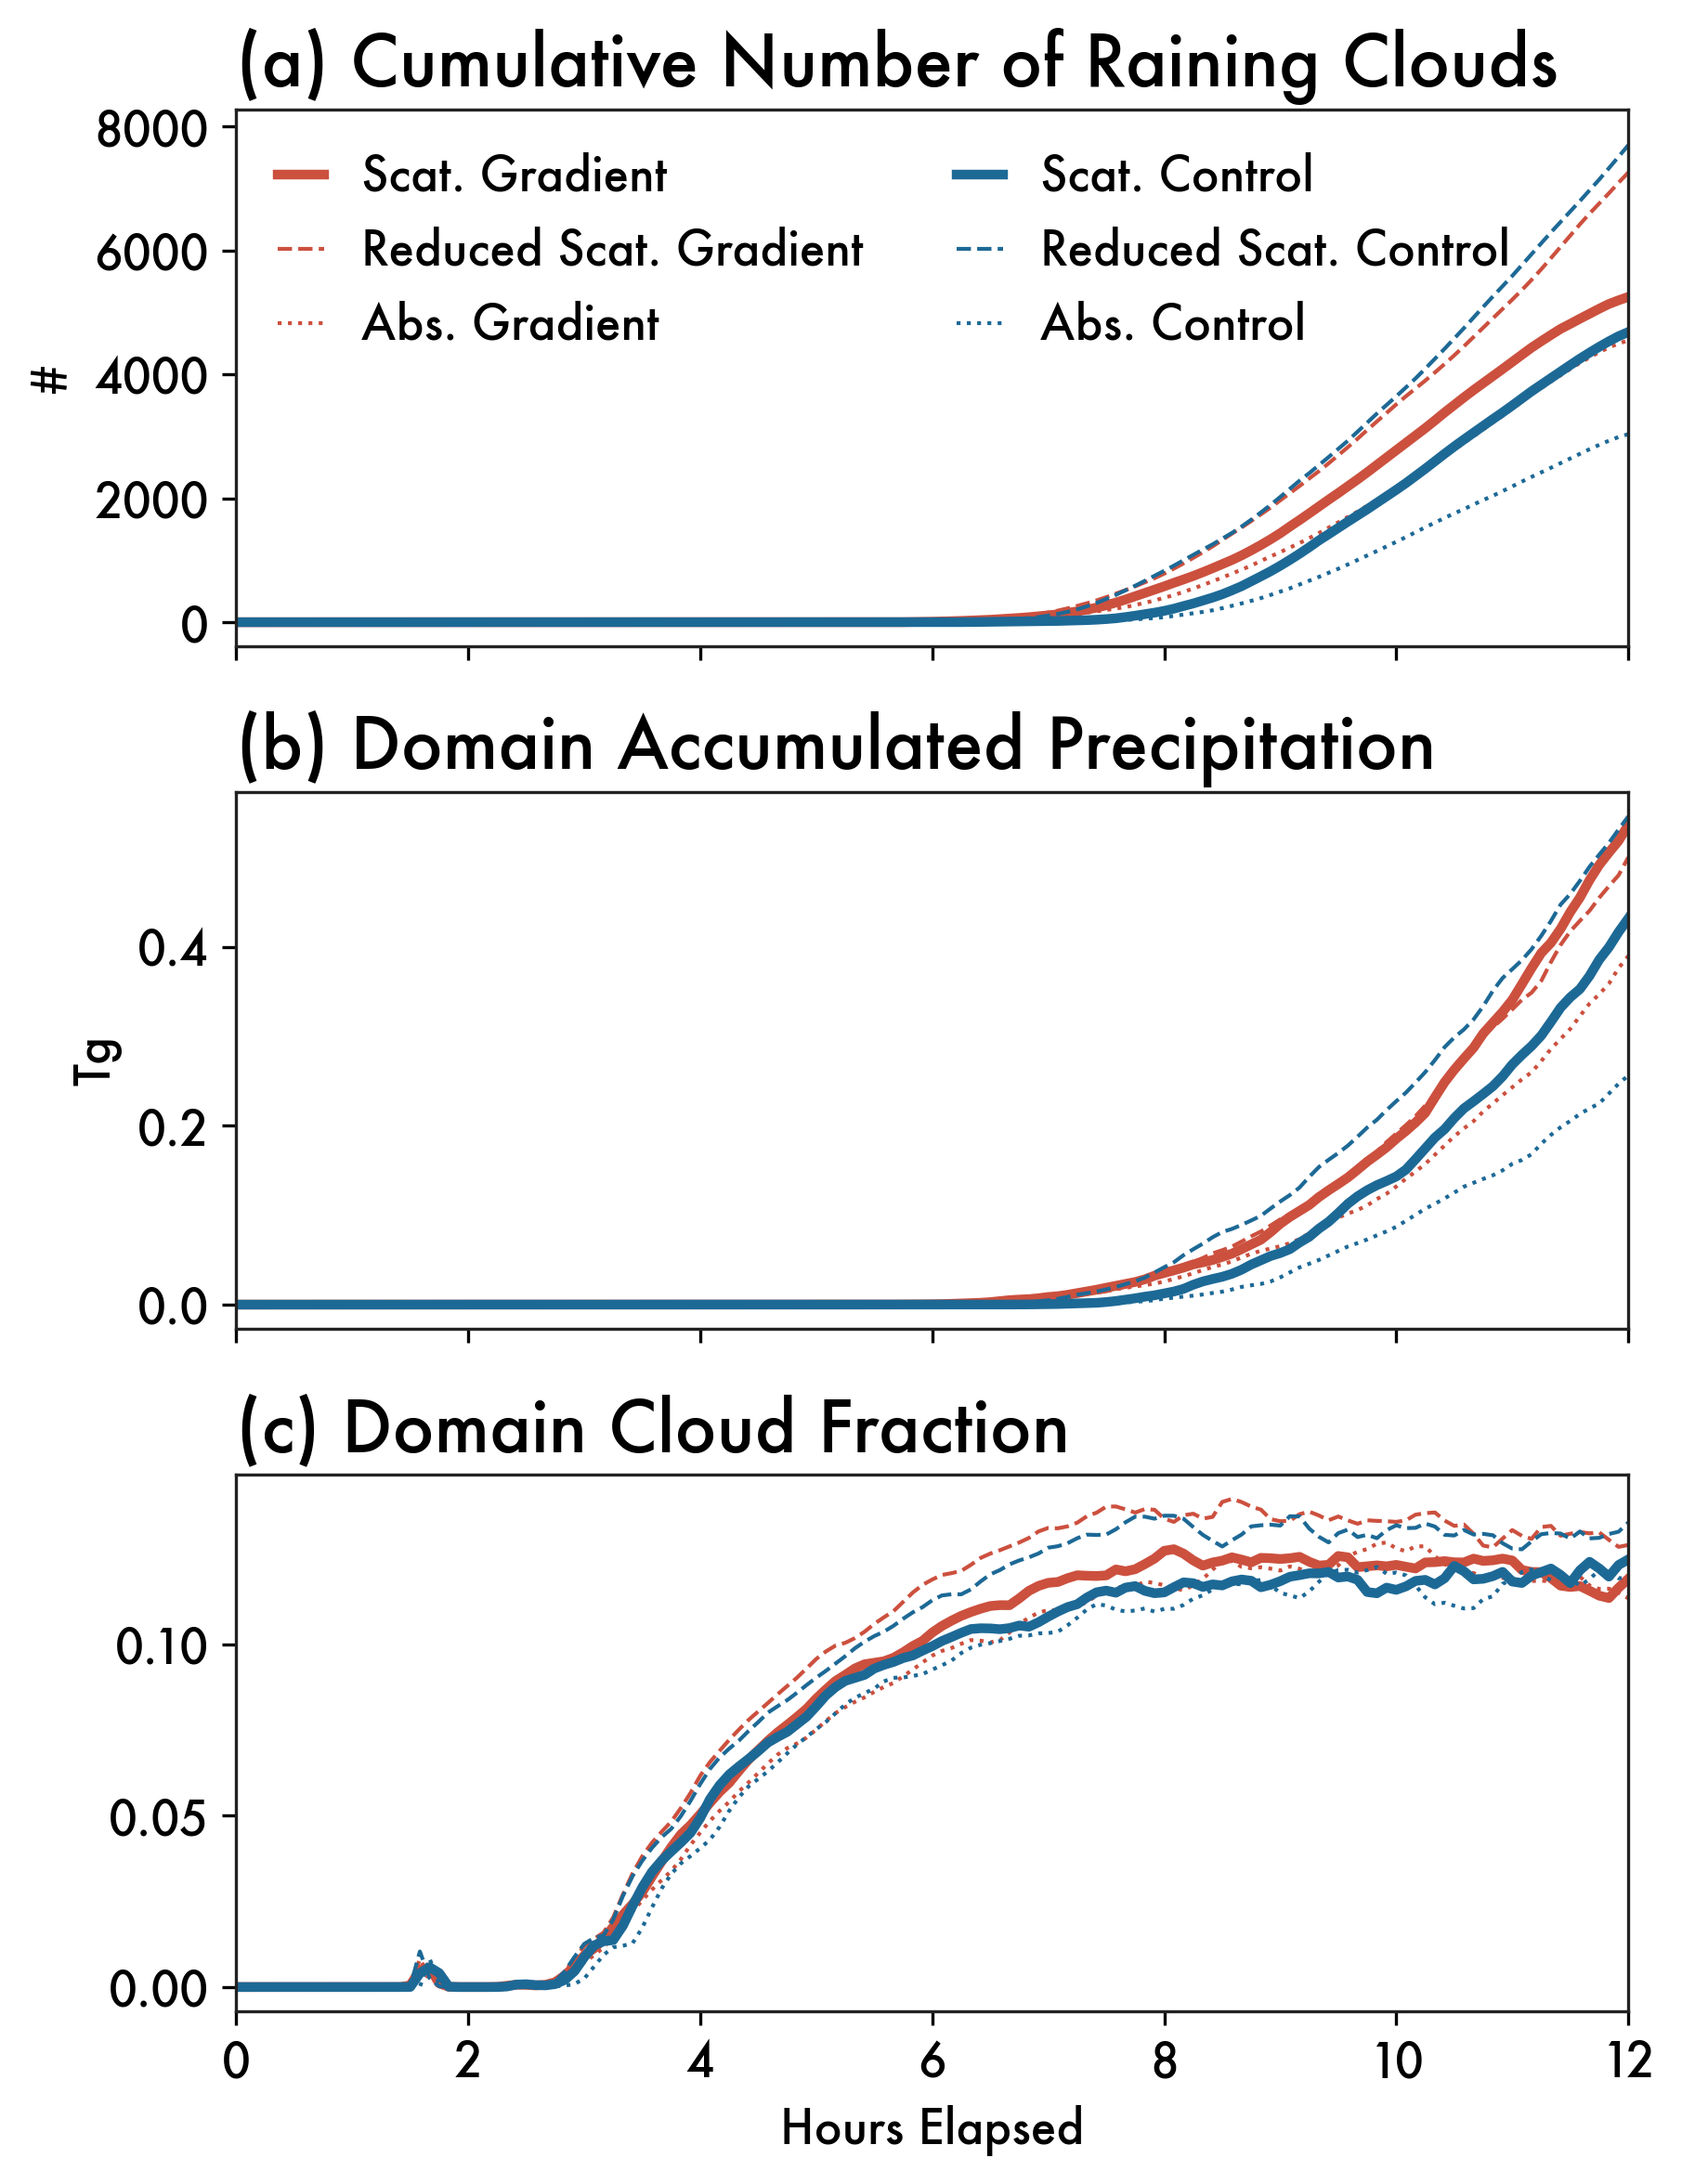

In [174]:
plot_vars = ['AccRainingUpdrafts','AccRain','CloudCover']
runs = ['grad.1000','grad.500','grad.1000.absc',
        'nograd.1000','nograd.500','nograd.1000.absc']
labels = ['Scat. Gradient','Reduced Scat. Gradient', 'Abs. Gradient',
          'Scat. Control','Reduced Scat. Control','Abs. Control']
colors = [red,red,red,blue,blue,blue]
lss = ['-','--',':','-','--',':']


fig, axes = plt.subplots(3,1,figsize=(6.2,8),sharex=True)

for ax, var in zip(axes,plot_vars):
    for run, lab,col,ls in zip(runs,
                                labels,
                                colors,
                                lss):
        plot_timeseries(ax,run,var,
                       col,ls,lab)
        
ax.set_xlim(0,12)

axes[0].set_ylabel('#')
axes[1].set_ylabel('Tg')

axes[0].set_title(f"(a) Cumulative Number of Raining Clouds")
axes[1].set_title(f"(b) Domain Accumulated Precipitation")
axes[2].set_title(f"(c) Domain Cloud Fraction")

axes[-1].set_xlabel('Hours Elapsed')

axes[0].legend(ncol=2,handlelength=1)

plt.savefig(f"{figPath}/timeseries-full.png",
                dpi=300,bbox_inches='tight')
    
plt.show()
plt.close('all')

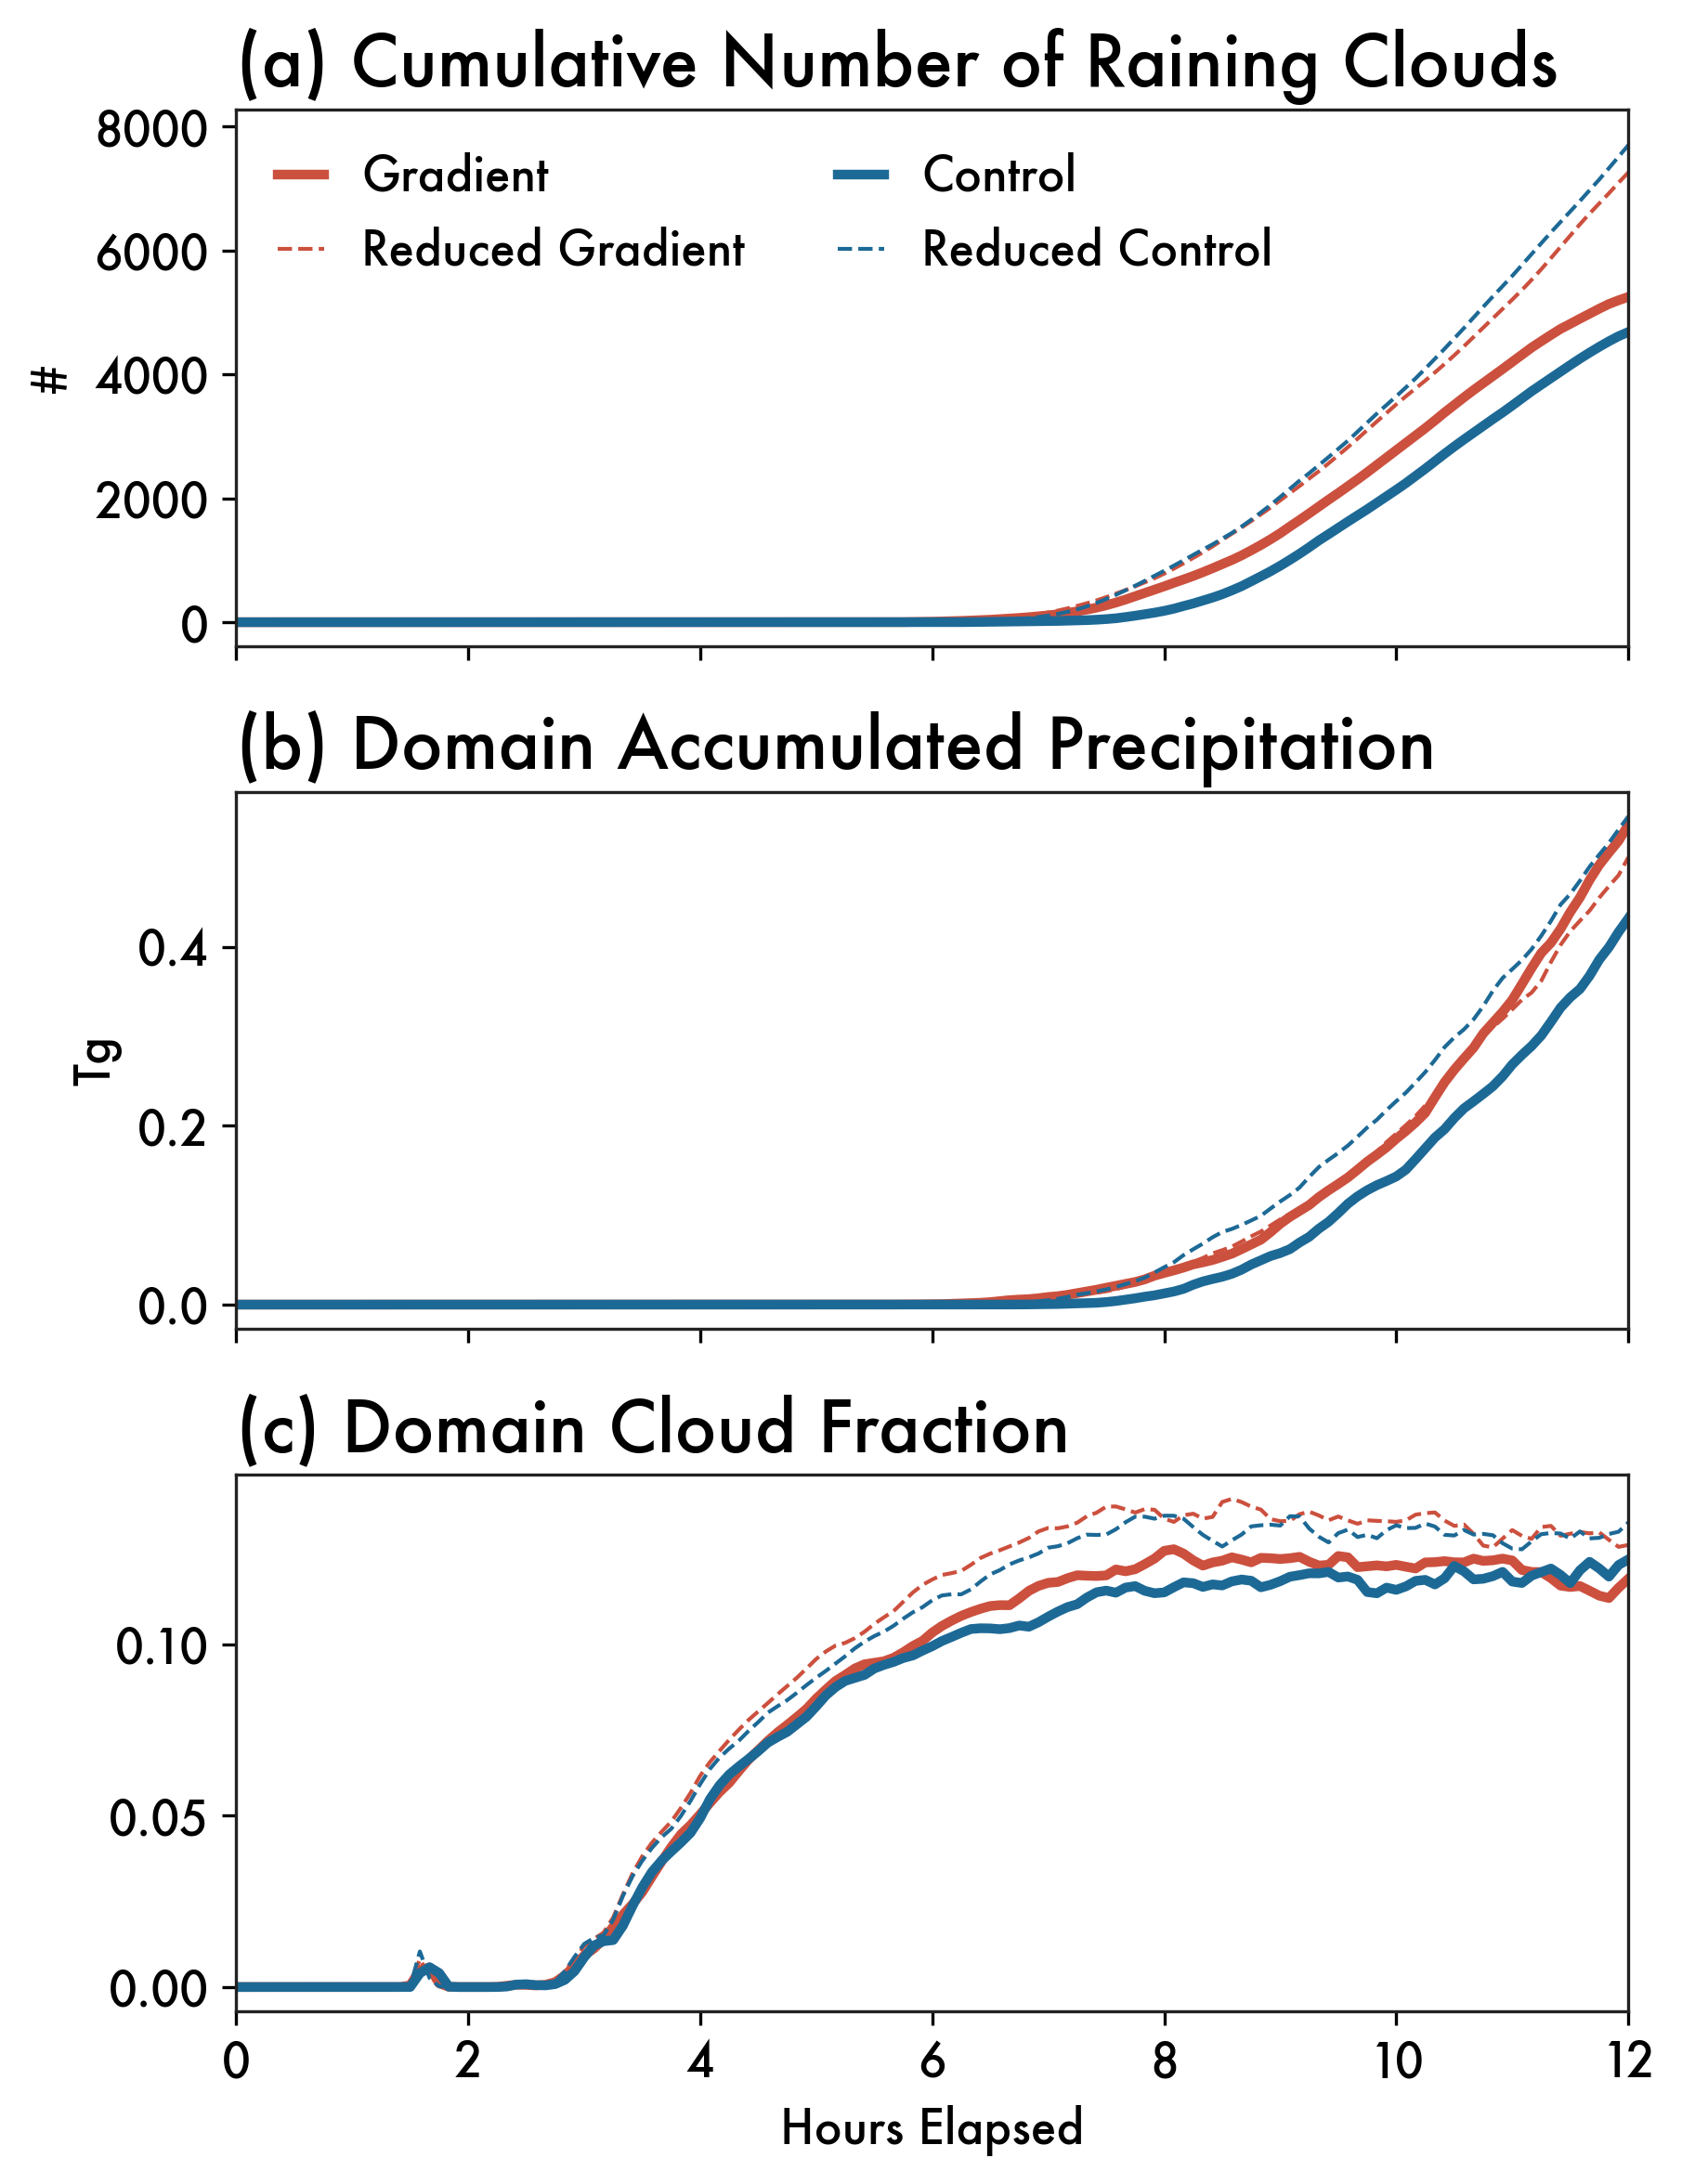

In [175]:
plot_vars = ['AccRainingUpdrafts','AccRain','CloudCover']
runs = ['grad.1000','grad.500',
        'nograd.1000','nograd.500',]
labels = ['Gradient','Reduced Gradient',
          'Control','Reduced Control',]
colors = [red,red,blue,blue]
lss = ['-','--','-','--',]


fig, axes = plt.subplots(3,1,figsize=(6.2,8),sharex=True)

for ax, var in zip(axes,plot_vars):
    for run, lab,col,ls in zip(runs,
                                labels,
                                colors,
                                lss):
        plot_timeseries(ax,run,var,
                       col,ls,lab)
        
ax.set_xlim(0,12)

axes[0].set_ylabel('#')
axes[1].set_ylabel('Tg')

axes[0].set_title(f"(a) Cumulative Number of Raining Clouds")
axes[1].set_title(f"(b) Domain Accumulated Precipitation")
axes[2].set_title(f"(c) Domain Cloud Fraction")

axes[-1].set_xlabel('Hours Elapsed')

axes[0].legend(ncol=2,handlelength=1)

plt.savefig(f"{figPath}/timeseries-scatteringonly.png",
                dpi=300,bbox_inches='tight')
    
plt.show()
plt.close('all')

In [92]:
for run in ['1000','1000.absc','500']:
    print(f'grad.{run}')
    grad = pd.read_pickle(f"{anaPath}grad.{run}/timeseries.pkl")
    nograd = pd.read_pickle(f"{anaPath}nograd.{run}/timeseries.pkl")

    h = 12

    print(f"Difference in accumulated precipitation after {h} hours is {(100*(grad.AccRain-nograd.AccRain)/nograd.AccRain).iloc[-1]:.2f}%")
    print(f"Precip onset is {5*(nograd.AccRain[nograd.AccRain!=0].index[0]-grad.AccRain[grad.AccRain!=0].index[0])} minutes sooner.")

    print()

    print(f"Difference in accumulated number of tracked updrafts is {(100*(grad.AccRainingUpdrafts-nograd.AccRainingUpdrafts)/nograd.AccRainingUpdrafts).iloc[-1]:.2f}%")
    print(f"Updraft onset is {5*(nograd.AccRainingUpdrafts[nograd.AccRainingUpdrafts!=0].index[0]-grad.AccRainingUpdrafts[grad.AccRainingUpdrafts!=0].index[0])} minutes sooner.")
    
    print()

grad.1000
Difference in accumulated precipitation after 12 hours is 24.22%
Precip onset is 60 minutes sooner.

Difference in accumulated number of tracked updrafts is 12.11%
Updraft onset is 30 minutes sooner.

grad.1000.absc
Difference in accumulated precipitation after 12 hours is 52.14%
Precip onset is 85 minutes sooner.

Difference in accumulated number of tracked updrafts is 49.88%
Updraft onset is 65 minutes sooner.

grad.500
Difference in accumulated precipitation after 12 hours is nan%
Precip onset is 40 minutes sooner.

Difference in accumulated number of tracked updrafts is -5.70%
Updraft onset is 45 minutes sooner.



# Figure: Across-Gradient Lineplot

In [162]:
def plot_lineplot(ax, run, var,hours0=0,hours=12,
                    run_color=None, run_ls=None, 
                    run_marker=None,run_label=None):
    if var =='RainingUpdrafts':
         plot = pd.read_pickle(f"{anaPath}{run}/mean_feature_count-{hours0}-{hours}.pkl")
    
    else:
        plot = pd.read_pickle(f"{anaPath}{run}/mean_surf_flux-{hours0}-{hours}.pkl")[var]
    
    if run.split('.')[-1]!='1000':
        lw = 1
    else:
        lw = 2.5
        
    out = ax.plot(plot.index,plot,
                 color=run_color, linestyle = run_ls,
                  label = run_label,marker=run_marker,
                 lw = lw)

    return(out)

/tmp/ipykernel_25692/1162078740.py:63: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.savefig(f"{figPath}/lineplot-full.png",
/home/gleung/miniconda3/envs/aerograd/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


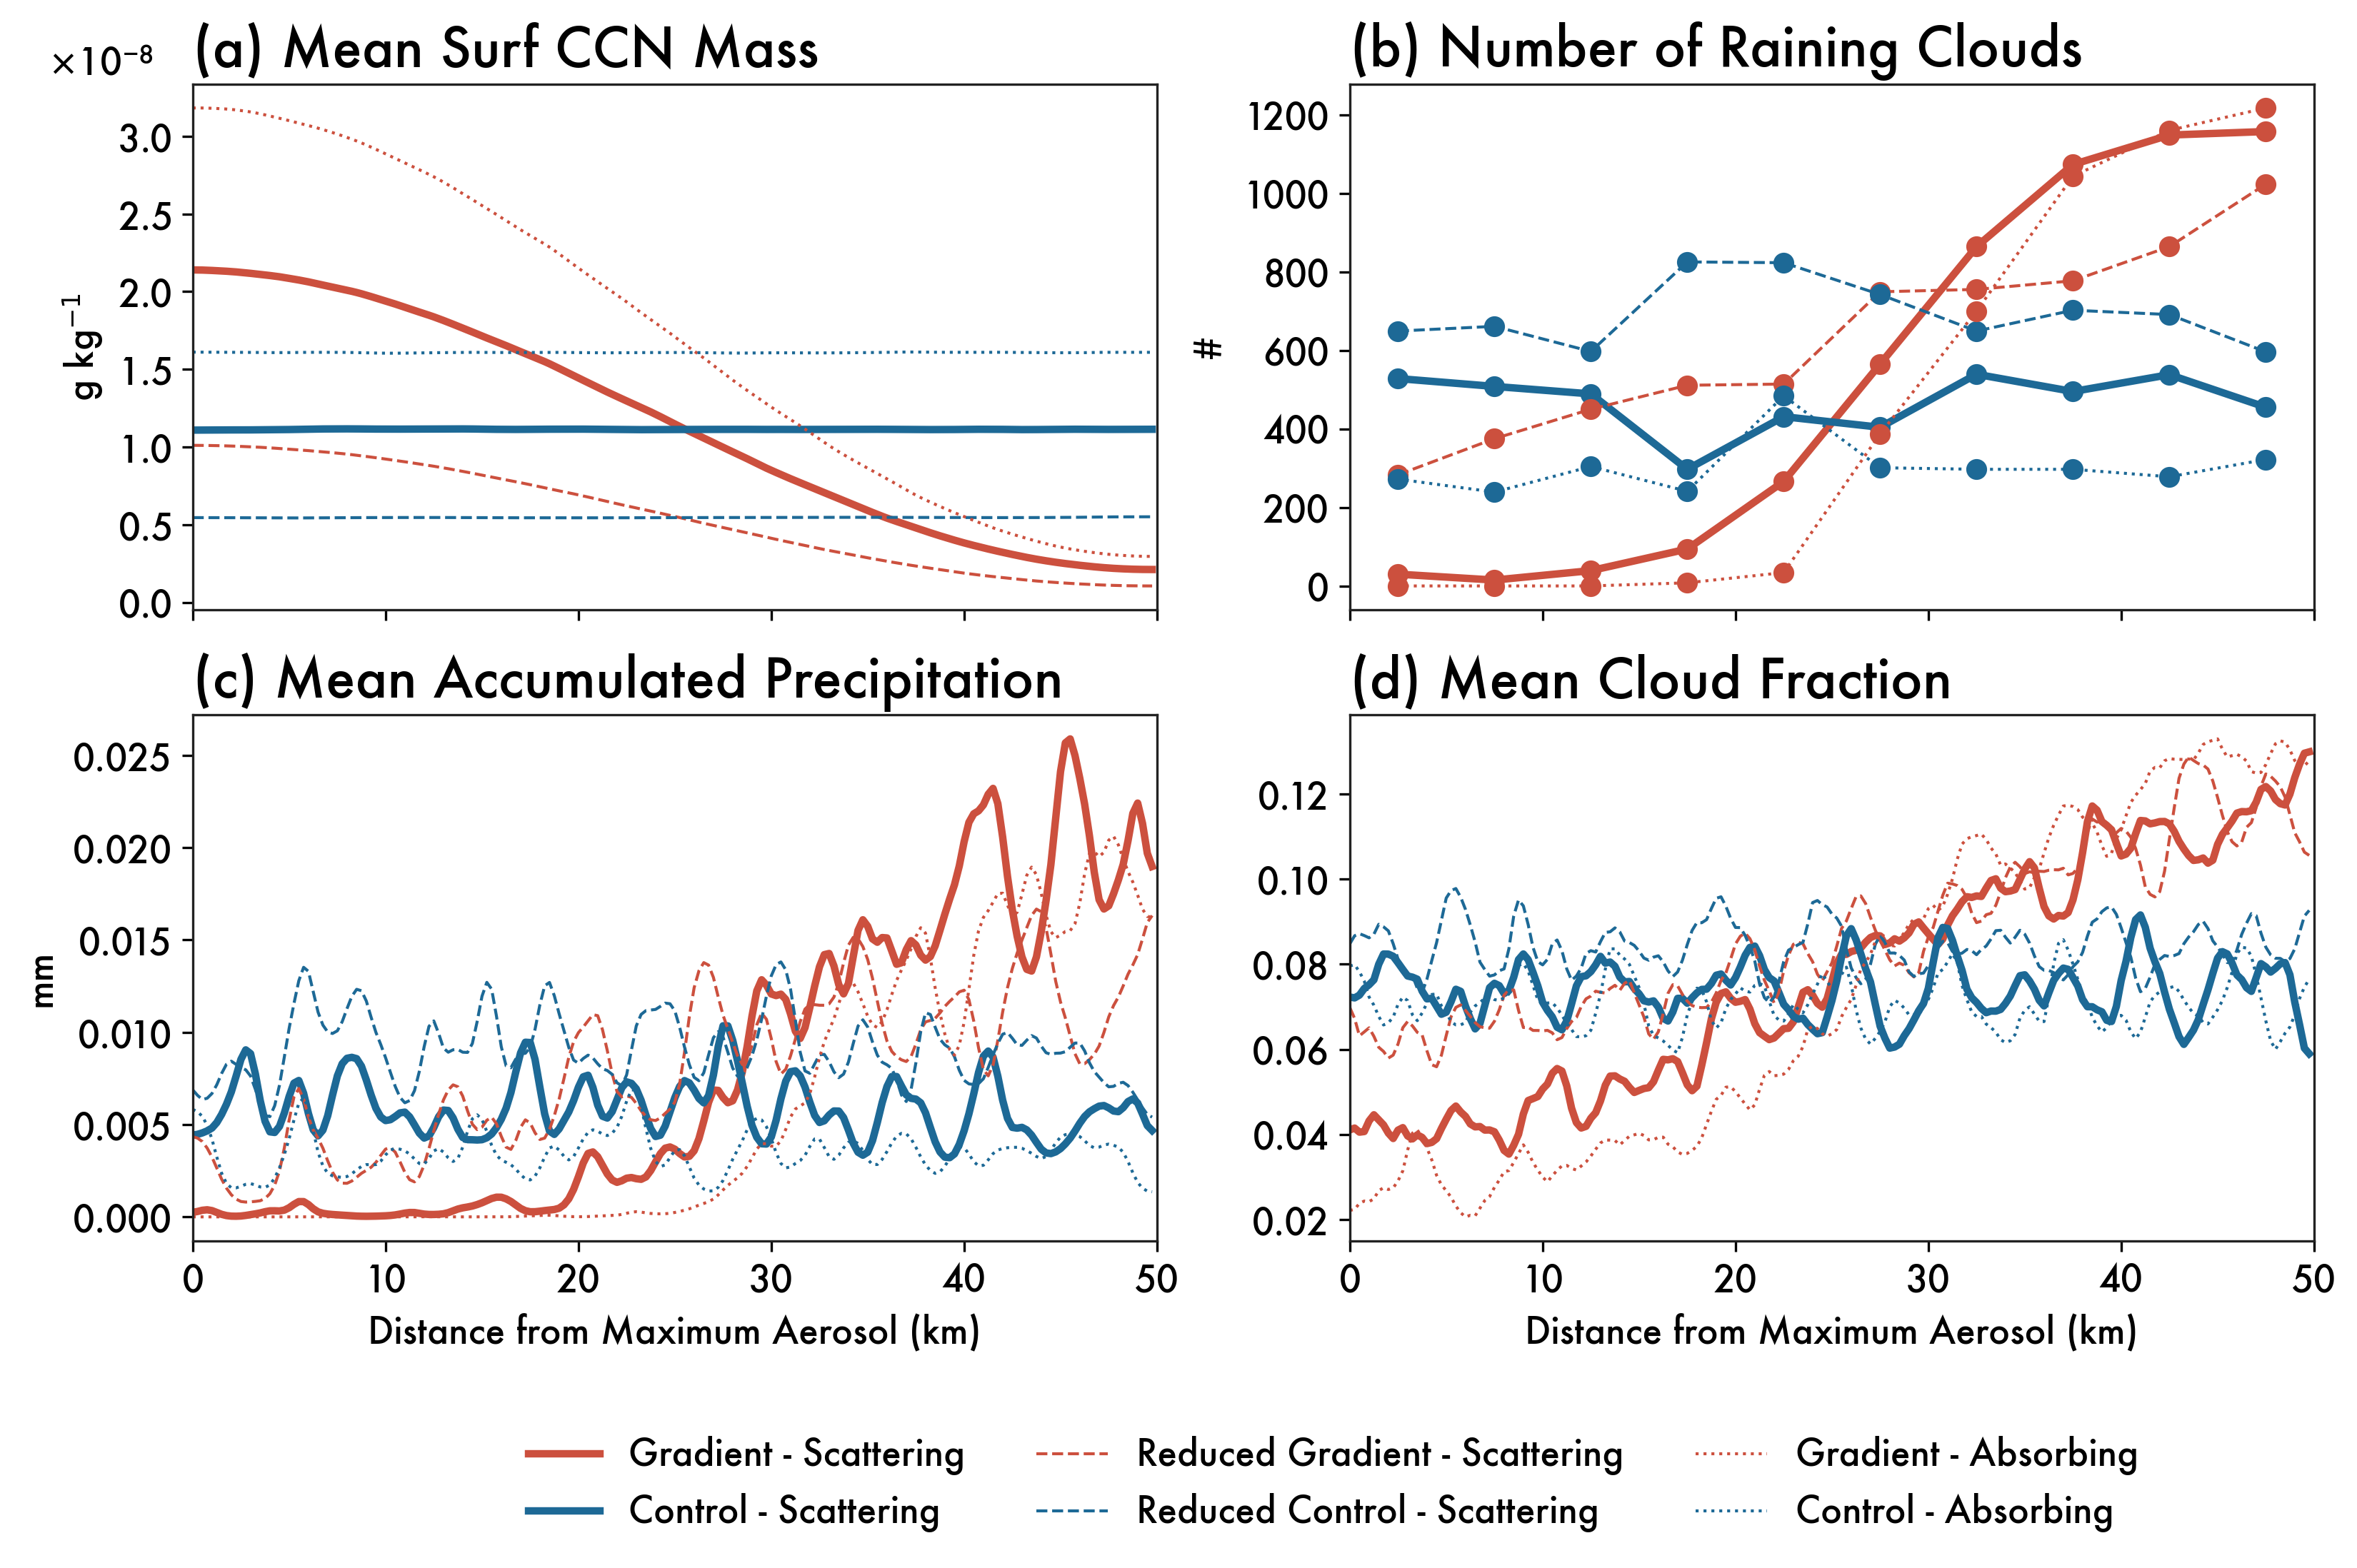

In [236]:
plot_vars = ['SurfCCN','RainingUpdrafts','ACCPR','cld_cover']

runs = ['grad.1000','nograd.1000',
        'grad.500','nograd.500',
        'grad.1000.absc','nograd.1000.absc']

labels = ['Gradient - Scattering','Control - Scattering',
          'Reduced Gradient - Scattering','Reduced Control - Scattering',
          'Gradient - Absorbing','Control - Absorbing']


fig, axes = plt.subplots(2,2,figsize=(11,6),sharex=True,
                        tight_layout=True)

axes = axes.flatten()

for ax, var in zip(axes,plot_vars):
    if var=='RainingUpdrafts':
        m = 'o'
    else:
        m = None
        
    for run, lab in zip(runs, labels):
        if run.split('.')[0]=='grad':
            col=red
        else:
            col=blue
            
        if run.split('.')[-1]=='1000':
            ls = '-'
        elif run.split('.')[-1]=='500':
            ls = '--'
        elif run.split('.')[-1]=='absc':
            ls = ':'
            
        plot_lineplot(ax,run,var,
                       run_color=col,run_ls=ls,
                      run_label=lab,run_marker=m)
        
        
ax.set_xlim(0,50)
        
axes[0].set_ylabel('g kg$^{-1}$')
axes[1].set_ylabel('#')
axes[2].set_ylabel('mm')

axes[0].set_title('(a) Mean Surf CCN Mass')
axes[1].set_title('(b) Number of Raining Clouds')
axes[2].set_title('(c) Mean Accumulated Precipitation')
axes[3].set_title('(d) Mean Cloud Fraction')

for ax in axes[-2:]:
    ax.set_xlabel('Distance from Maximum Aerosol (km)')

axes[0].yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
axes[0].get_yaxis().get_offset_text().set_position((-0.15,0))

axes[1].set_xlim(0,50)

axes[0].legend(bbox_to_anchor=(0.315, -1.51), 
           loc='upper left', ncol=3)

plt.savefig(f"{figPath}/lineplot-full.png",
                dpi=300,bbox_inches='tight')
plt.show()
plt.close('all')

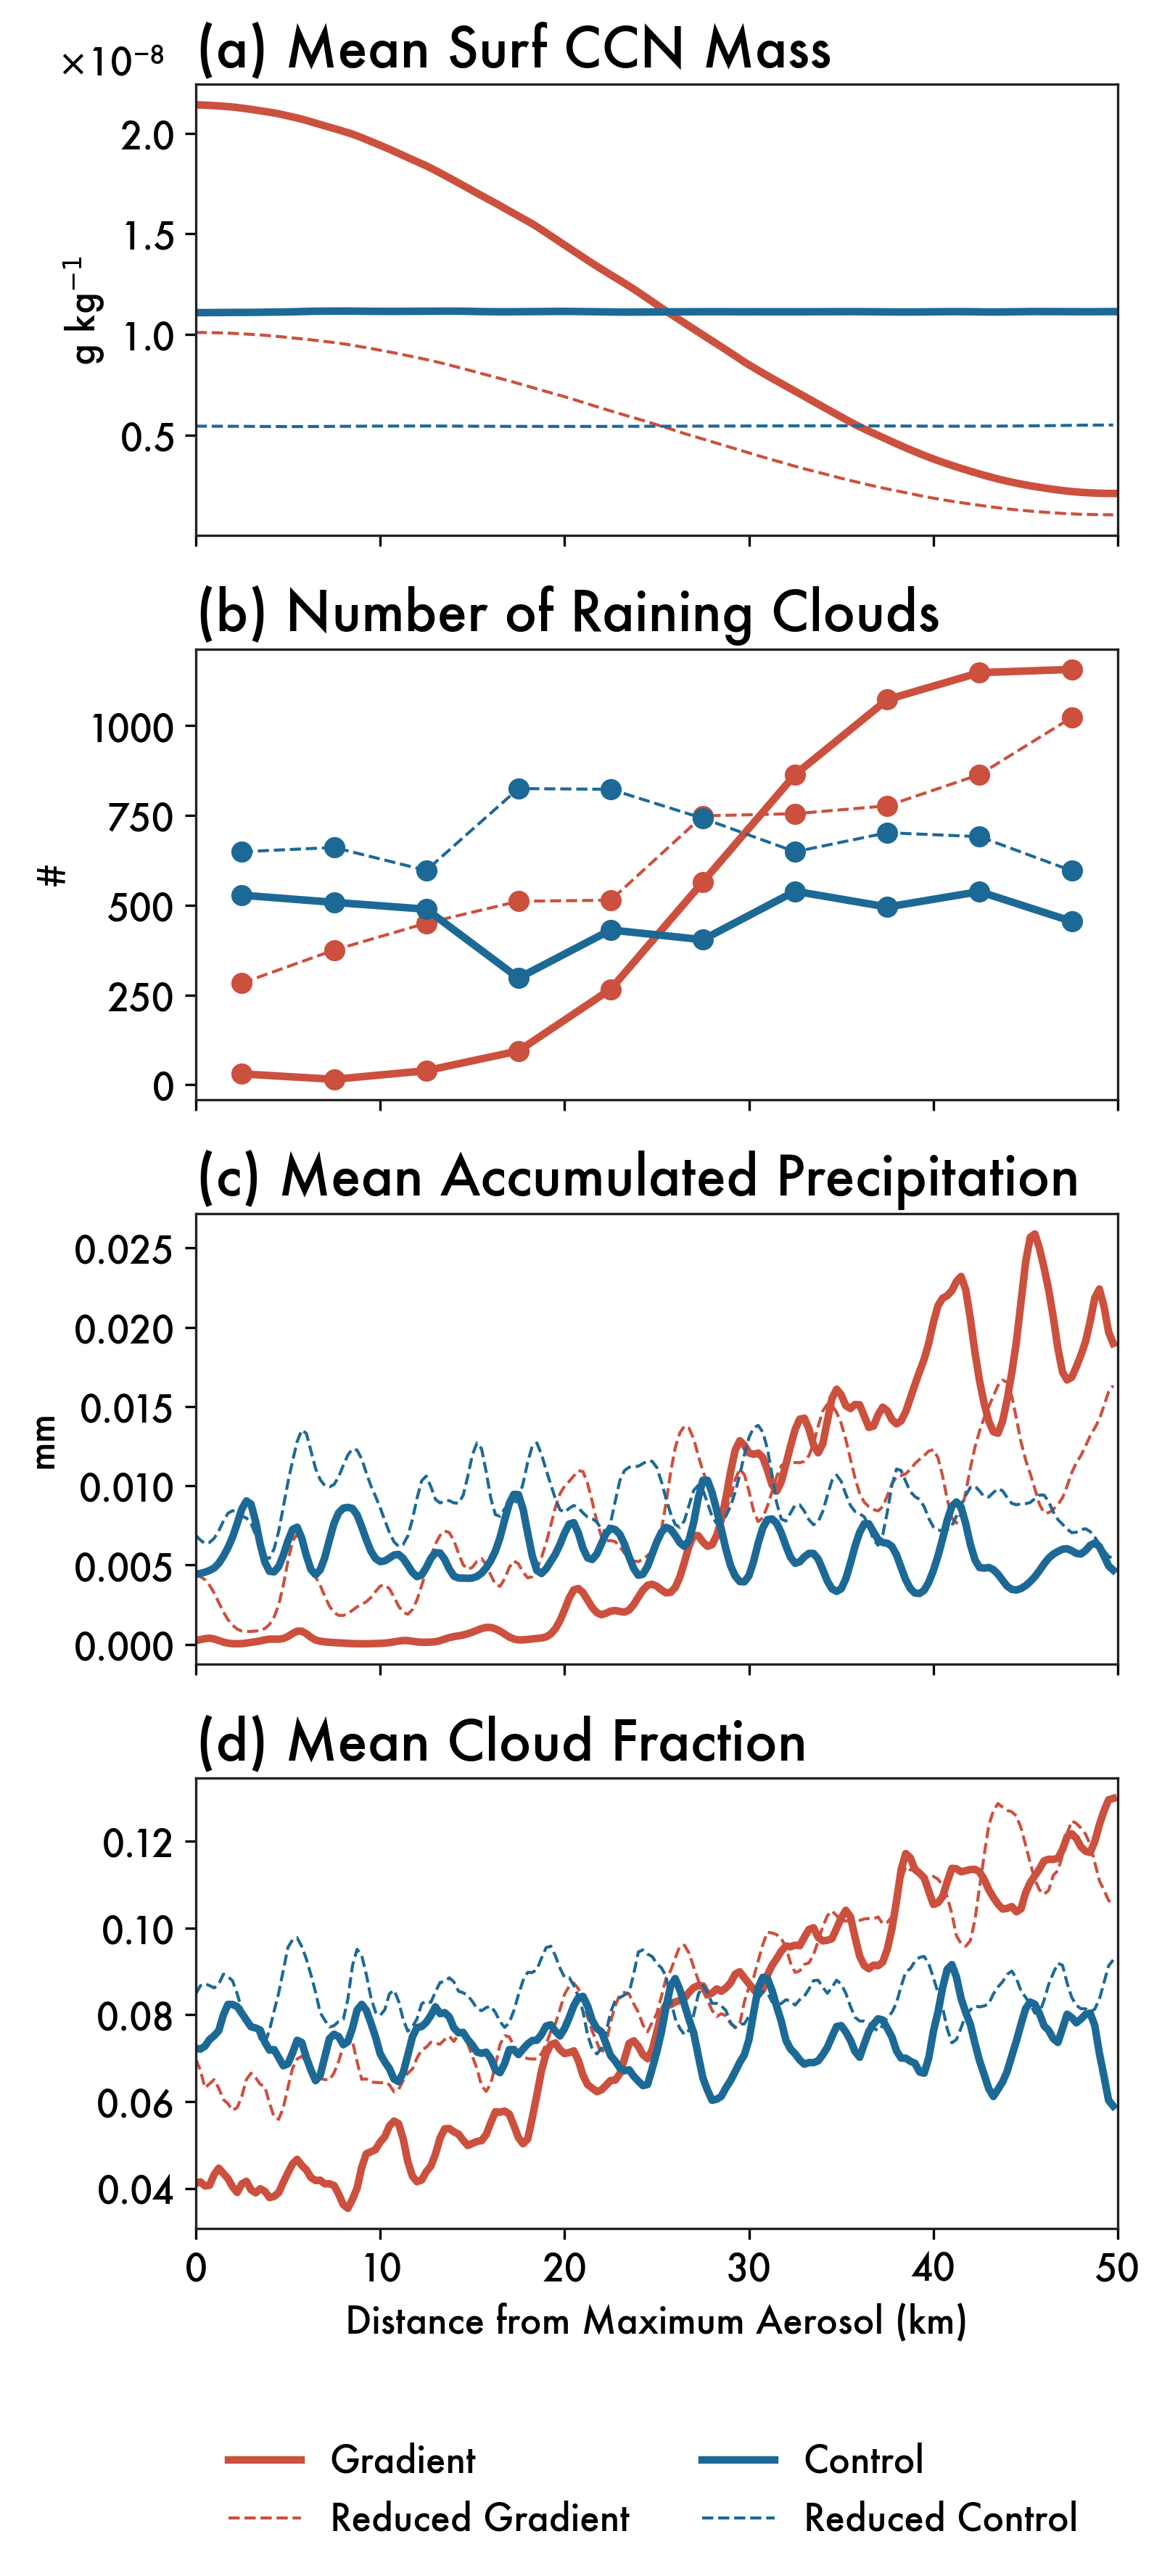

In [164]:
plot_vars = ['SurfCCN','RainingUpdrafts','ACCPR','cld_cover']

runs = ['grad.1000','grad.500',
        'nograd.1000','nograd.500',]
labels = ['Gradient','Reduced Gradient',
          'Control','Reduced Control',]
colors = [red,red,blue,blue]
lss = ['-','--','-','--',]

fig, axes = plt.subplots(4,1,figsize=(5.5,12),sharex=True)

for ax, var in zip(axes,plot_vars):
    if var=='RainingUpdrafts':
        m = 'o'
    else:
        m = None
        
    for run, lab,col,ls in zip(runs,
                                labels,
                                colors,
                                lss):
        plot_lineplot(ax,run,var,
                       run_color=col,run_ls=ls,
                      run_label=lab,run_marker=m)
        
        
ax.set_xlim(0,50)
        
axes[0].set_ylabel('g kg$^{-1}$')
axes[1].set_ylabel('#')
axes[2].set_ylabel('mm')


axes[0].set_title('(a) Mean Surf CCN Mass')
axes[1].set_title('(b) Number of Raining Clouds')
axes[2].set_title('(c) Mean Accumulated Precipitation')
axes[3].set_title('(d) Mean Cloud Fraction')

axes[-1].set_xlabel('Distance from Maximum Aerosol (km)')

axes[0].yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
axes[0].get_yaxis().get_offset_text().set_position((-0.15,0))

axes[1].set_xlim(0,50)

axes[-1].legend(bbox_to_anchor=(0, -0.4), loc='upper left', ncol=2)

plt.savefig(f"{figPath}/lineplot-scatteringonly.png",
                dpi=300,bbox_inches='tight')
plt.show()